# NFL Pro Day Data
## Simple Exploratory Data Analysis Example

First thing we have to do (coding wise) with any notebook, import the libraries we'll be using. I often just copy and paste these over from previous notebooks as they don't take long to load, and I almost always use these four libraries

In [1]:
#Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('mode.chained_assignment', None)
%config InlineBackend.figure_format = 'retina'

### Cleaning

With that out of the way, let's load in some data. The large majority of exploratory data analysis in python can be done with the library "pandas," a very versatile tool which even lets you read in data directly from a google sheet - something we'll take advantage of here. Thanks to @AlexKatson on twitter for providing this data

In [2]:
#Here's our sheet id, the unique identifier of this google sheet. 
#However, there are multiple "sheets" (tabs?) here, so we want to get the relevant one 
sheet_id = '1VvCg4S-Srf5ZhywnIBxSxb3Ocibd7Zq_LqGx-N2sQdM'
tab_name = 'Results'
#We use an fstring to easily reuse this code for future sheets, only needing to replace sheet_id and tab_name
#This "f" before the string here allows us to insert these variables in the middle of the string, 
#which point to the sheet_id and tab_name we want
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={tab_name}'

Reading in the csv is now simple! 

In [3]:
#Manually adding some columns here as they aren't reading in correctly, and the sheet is read only
column_names = ['player',
               'position',
               'school',
               'height',
               'weight',
               'hand',
               'arm',
               'wing',
               'dash',
               'bench',
               'vertical',
               'broad',
               'shuttle',
               'cone']
#Read the csv, telling pandas we want our own column names and so skipping the first row
df = pd.read_csv(url, names=column_names, skiprows=1)
#Look at first few rows
df.head(5)

,player,position,school,height,weight,hand,arm,wing,dash,bench,vertical,broad,shuttle,cone
0,Trevor Lawrence,QB,Clemson,6055.0,213.0,10,31 4/8,78 2/8,NaN,NaN,NaN,NaN,NaN,NaN
1,Milton Williams,IDL,Louisiana Tech,6030.0,286.0,--,--,--,4.63,32.0,35.0,NaN,NaN,NaN
2,Jonathan Adams Jr.,WR,Arkansas State,6030.0,218.0,--,--,--,4.48,NaN,41.5,126.0,4.13,6.9
3,Ja'Marr Chase,WR,LSU,NaN,NaN,--,--,--,NaN,23.0,NaN,NaN,NaN,NaN
4,Rashod Bateman,WR,Minnesota,NaN,NaN,--,--,--,4.39,NaN,NaN,NaN,NaN,NaN


Looks good! But we've got a lot of missing data "NaN", and more troublesome a bunch of "--" strings. NaN stands for "Not a Number", and is a very important part of any exploratory data analysis. NaN values will be treated as nonexistent if we do things such as take the mean of a column, or plot our data. In other words it tells our computer, "there is no data here." The "--" string, however, may tell **us** there's no data in that cell, but to our computer (and specifically the pandas library) it is perceived as meaningful. Let's remove it

In [4]:
#Just one line for this, almost too good to be true! We've searched each cell for the "--" string, replaced it with NaN
df.replace('--', np.nan, regex=True, inplace=True)

Alright we've taken care of the missing data, let's take a look at what type of data we have in each column

In [5]:
#Show the data type for each column in our dataframe
df.dtypes

player       object
position     object
school       object
height      float64
weight      float64
hand         object
arm          object
wing         object
dash        float64
bench       float64
vertical    float64
broad       float64
shuttle     float64
cone        float64
dtype: object

I won't get too into data types here as this is meant as a brief walkthrough, but you'll notice we have two types. Float64, and "object." Float64 can be thought of as a number, specifically a number that will take up 64 bits of memory (in other words a number with the potential for many decimal places). This is what we want, if our data is meant to be represented as a continous variable. 

"Object" on the other hand refers to text variables, or text mixed with numbers. You'll notice this is the case for player, position, & school, which makes sense. These are clearly meant to be text variables. But how about hand, arm, and wing? Aren't these numbers?

Well, because these variables are represented as fractions, e.g. Trevor Lawrence's 31 4/8 arm length, pandas is interpreting this as text and not numbers. This means an arithmetic operation, such as addition, would not work. Let's try it to be sure

In [6]:
#square brackets with the name of the column in quotes is how to access specific columns of a df
df['hand'] + df['arm']

0          1031 4/8
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
656     9 3/833 5/8
657    10 1/831 4/8
658     8 4/830 5/8
659     9 5/832 1/8
660     9 5/831 6/8
Length: 661, dtype: object

We've added the columns, but instead of adding the numbers in a meaningful way, it has simply appended the two text cells together. Let's fix that by converting these to numbers. This gets a bit trickier than anything we've done so far, but is still just a few lines of code.

In [7]:
#Only interested in rows that have a fraction here, which means they have a space. 
#df.loc is pandas language for "the rows (or location) where", and then we tell it what condition to satisfy.
#In this case, the string contains a space
fract_df = df.loc[(df['hand'].str.contains(' ', na=False))]

#Get a df of the other rows, the ones with no fraction. The "~" here tells pandas to return the opposite of our condition, 
#rows which turn up False
whole_df = df.loc[~(df['hand'].str.contains(' ', na=False))]

In [8]:
#Fixing the whole_df folk is easy - just convert the strings to numbers
whole_df['hand_new'] = pd.to_numeric(whole_df['hand'])

In [9]:
#Get just the fraction (the stuff after the space), and then use "pd.eval" to convert it into a decimal
fract_df['hand_dec'] = fract_df['hand'].str.split(' ').str[-1].apply(pd.eval)
#Now get the first measure, the whole number
fract_df['hand_whole'] = pd.to_numeric(fract_df['hand'].str.split(' ').str[0])
#Add them back together
fract_df['hand_new'] = fract_df['hand_dec'] + fract_df['hand_whole']
#Visualize what we've done. Two square brackets are used here because we're looking at more than one column
fract_df[['hand','hand_new']]

,hand,hand_new
15,9 6/8,9.750
16,9 2/8,9.250
17,7 3/8,7.375
18,8 1/8,8.125
19,9 6/8,9.750
...,...,...
656,9 3/8,9.375
657,10 1/8,10.125
658,8 4/8,8.500
659,9 5/8,9.625


Looks pretty good! Now lets append these two dataframes (those who had fractions, and those who didn't)

In [10]:
#We don't need any of these hand columns anymore now that we have our new one, so we're dropping them after we merge the two dfs
new_df = pd.concat((whole_df, fract_df)).drop(columns=['hand_dec','hand_whole','hand'])

In [11]:
#Check that this worked
new_df.dtypes

player       object
position     object
school       object
height      float64
weight      float64
arm          object
wing         object
dash        float64
bench       float64
vertical    float64
broad       float64
shuttle     float64
cone        float64
hand_new    float64
dtype: object

We can see this worked - hand_new is float64, not object. Now, we still have two more columns to go - arm, and wing. If we find ourselves having to repeat the same set of transformations to our data multiple times, it's probably best to create a what's called a "function." I'm going to do so now, but won't get too deep into the specific syntax or theory behind functions for this post.

In [12]:
def clean_fractions(df, column_names):
    #Was going to try and write this to work for any amount of column names, but frankly, I got lazy. 
    #Sometimes the investment to make something clean and more compact isn't worth it when you can spend that time
    #Doing more analysis/exploration
    c_name = column_names[0]
    fract_df = df.loc[(df[c_name].str.contains(' ', na=False))]
    whole_df = df.loc[~(df[c_name].str.contains(' ', na=False))]
    
    whole_df[f'{c_name}_new'] = pd.to_numeric(whole_df[c_name])

    #Get just the fraction (the stuff after the space), and then use "pd.eval" to convert it into a decimal
    fract_df[f'{c_name}_dec'] = fract_df[c_name].str.split(' ').str[-1].apply(pd.eval)
    #Get the first measure, the whole number
    fract_df[f'{c_name}_whole'] = pd.to_numeric(fract_df[c_name].str.split(' ').str[0])
    #Add them back together
    fract_df[f'{c_name}_new'] = fract_df[f'{c_name}_dec'] + fract_df[f'{c_name}_whole']
    #New df
    new_df = pd.concat((whole_df, fract_df)).drop(columns=[f'{c_name}_dec',f'{c_name}_whole',c_name])
    #Return the new df
    return new_df

In [13]:
#Run the function a few times, once for each column name. As mentioned above, this is not the best way of doing this -
#But the cool thing about coding is, if it works, it works!
hand_df = clean_fractions(df, ['hand'])
arm_df = clean_fractions(hand_df, ['arm'])
clean_df = clean_fractions(arm_df, ['wing'])

clean_df.dtypes

player       object
position     object
school       object
height      float64
weight      float64
dash        float64
bench       float64
vertical    float64
broad       float64
shuttle     float64
cone        float64
hand_new    float64
arm_new     float64
wing_new    float64
dtype: object

And look at that, it works! We've done a fair bit of work here just to clean up this data, so let's save it in case our kernel shuts down on us.

In [14]:
#One last thing, let's remove the "_new" part of the column name, replacing it with nothing
clean_df.columns = clean_df.columns.str.replace('_new', '')
clean_df.head(2)

,player,position,school,height,weight,dash,bench,vertical,broad,shuttle,cone,hand,arm,wing
1,Milton Williams,IDL,Louisiana Tech,6030.0,286.0,4.63,32.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Jonathan Adams Jr.,WR,Arkansas State,6030.0,218.0,4.48,NaN,41.5,126.0,4.13,6.9,NaN,NaN,NaN


In [15]:
clean_df.to_csv('clean_pro_day_results.csv', index=False)

### Visualizing

Alright, so what are some things we can do with this data now that it's cleaned? Well first, we can sort it to see who has the lowest or heighest values in certain columns

In [16]:
#Sorting in pandas (.sort_values()) sorts A-Z, or low to high by default, 
#so putting ascending=False finds us the tallest players.
#We then use .head() to see the top 20
clean_df.sort_values(by=['height'], ascending=False).head(10)

,player,position,school,height,weight,dash,bench,vertical,broad,shuttle,cone,hand,arm,wing
255,Spencer Brown,OT,Northern Iowa,6082.0,311.0,4.94,29.0,31.5,117.0,4.40,6.96,10.375,34.750,82.625
433,Tommy Doyle,OT,Miami (OH),6080.0,320.0,5.12,24.0,33.5,111.0,4.57,7.42,10.375,35.125,83.875
525,Stone Forsythe,OT,Florida,6080.0,307.0,5.13,25.0,27.5,103.0,4.63,7.47,10.000,34.375,83.250
303,Greg Eiland,OT,Mississippi State,6077.0,321.0,5.77,8.0,26.5,97.0,NaN,NaN,10.875,37.000,88.125
289,Grant Hermanns,OT,Purdue,6074.0,300.0,5.29,26.0,27.0,107.0,4.58,7.76,9.875,33.500,79.250
55,Josh Ball,OT,Marshall,6073.0,308.0,5.19,28.0,27.5,106.0,4.67,7.75,10.000,35.000,81.625
174,Walker Little,OT,Stanford,6073.0,313.0,5.30,24.0,29.5,111.0,4.59,7.44,10.125,33.750,81.750
494,Ben Knutson,OT,Tulane,6071.0,301.0,5.27,12.0,24.0,99.0,4.85,8.01,9.875,32.375,77.375
169,Thomas Schaffer,IDL,Stanford,6066.0,302.0,NaN,23.0,NaN,NaN,NaN,NaN,9.250,32.625,79.250
327,Tony Poljan,TE,Virginia,6066.0,251.0,4.89,23.0,33.5,113.0,4.50,7.34,9.375,33.500,79.000


What about seeing what the distribution of height looks like in this class?

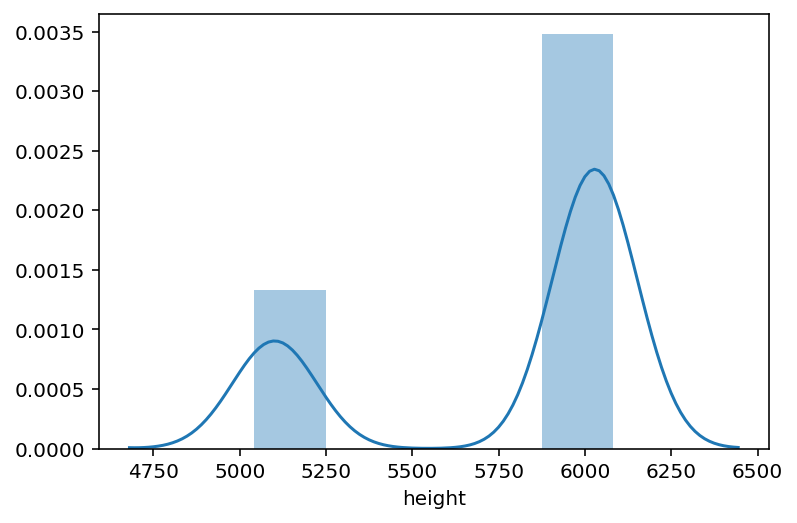

In [17]:
sns.distplot(clean_df['height'])

Well that looks funky... this is why EDA is so important. There's clearly something going on with the height variable here, as we've got no reason to expect such a big gap between heights... and what are these dimensions?? With some [twitter investigation](https://twitter.com/EthanCDouglas/status/1382130115694399490?s=20) I was able to nail down what exactly these heights mean, and a great example of why domain expertise can go a long way in data science. Let's convert this archaic system to inches. 

In [18]:
#Only rows in which we have values here
df = clean_df.loc[(clean_df['height'].notnull())]
na_df = clean_df.loc[~(clean_df['height'].notnull())]
#Convert to string to parse this monstrosity
df['height'] = df['height'].astype(str)
#Get just the feet portion, converted to inches
df['height_ft'] = df['height'].str.slice(0,1).astype(float)*12
#Just inches
df['height_inch'] = df['height'].str.slice(1,3).astype(float)
#1/8 inches
df['height_dec'] = df['height'].str.slice(3,4).astype(float)/8
#Combine
df['height_new'] = df['height_inch'] + df['height_dec'] + df['height_ft']

#Similar process as before
clean_df = pd.concat((df,na_df)).drop(columns=['height_ft','height_inch','height_dec','height'])
clean_df.columns = clean_df.columns.str.replace('_new', '')
#Let's resave this
clean_df.to_csv('clean_pro_day_results.csv', index=False)

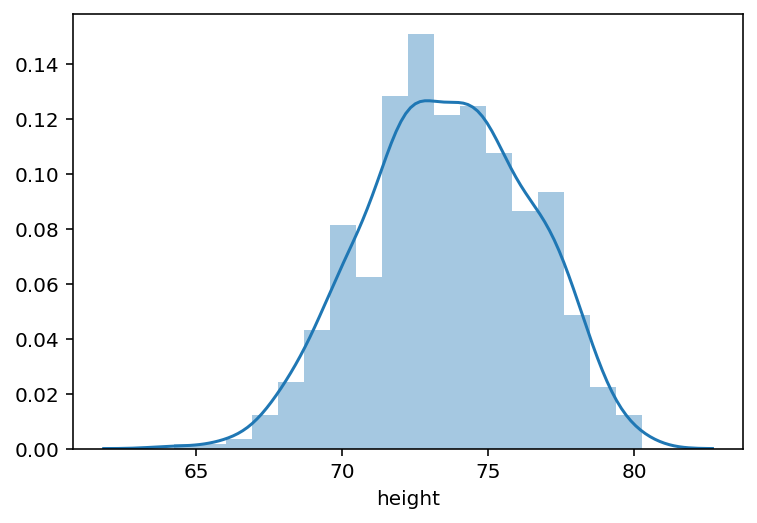

In [19]:
sns.distplot(clean_df['height'])

Much better!

What about who takes up the most space overall - height x weight? We're going to call this "mass", even though we know that isn't actually true mass

In [20]:
clean_df['mass'] = clean_df['height'] * clean_df['weight']
clean_df.sort_values(by=['mass'], ascending=False).head(5)

,player,position,school,weight,dash,bench,vertical,broad,shuttle,cone,hand,arm,wing,height,mass
119,Ben Cleveland,IOL,Georgia,354.0,5.05,30.0,28.0,102.0,4.88,NaN,9.750,33.000,79.125,78.375,27744.750
547,Tyler Shelvin,IDL,LSU,350.0,5.41,NaN,28.5,97.0,5.08,8.15,10.250,33.625,80.250,74.125,25943.750
260,Deonte Brown,IOL,Alabama,344.0,5.57,NaN,27.0,96.0,5.18,8.33,9.125,32.375,80.750,75.250,25886.000
261,Landon Dickerson,IOL,Alabama,333.0,NaN,NaN,NaN,NaN,NaN,NaN,10.375,33.250,81.125,77.625,25849.125
303,Greg Eiland,OT,Mississippi State,321.0,5.77,8.0,26.5,97.0,NaN,NaN,10.875,37.000,88.125,79.875,25639.875


We can see that Ben Cleveland is the largest human in this class (by pro day measurements, at least). How could we visualize this? 

We've got a few different options. I won't get indepth on data viz here, or how to modify plots, instead just showing some basics.

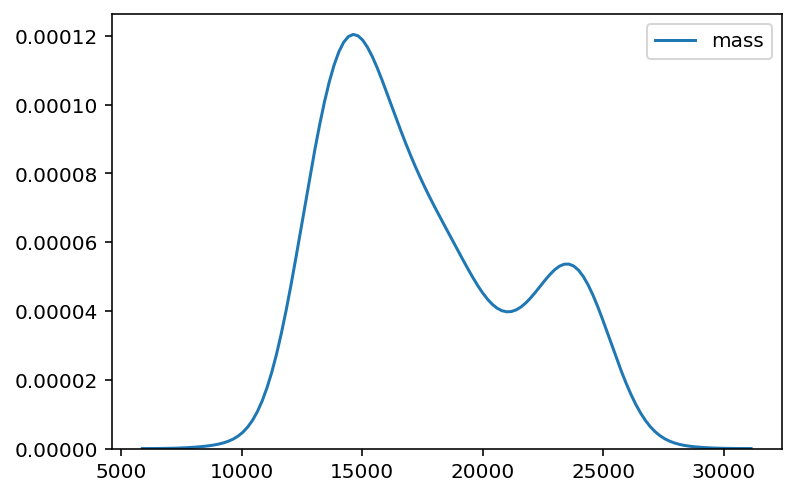

In [21]:
#We'll start with a density plot
sns.kdeplot(clean_df['mass'])

This is an ugly plot, *but* it does show us the distribution of mass fairly well. Another option is to break up the mass variable we've created into it's component plots

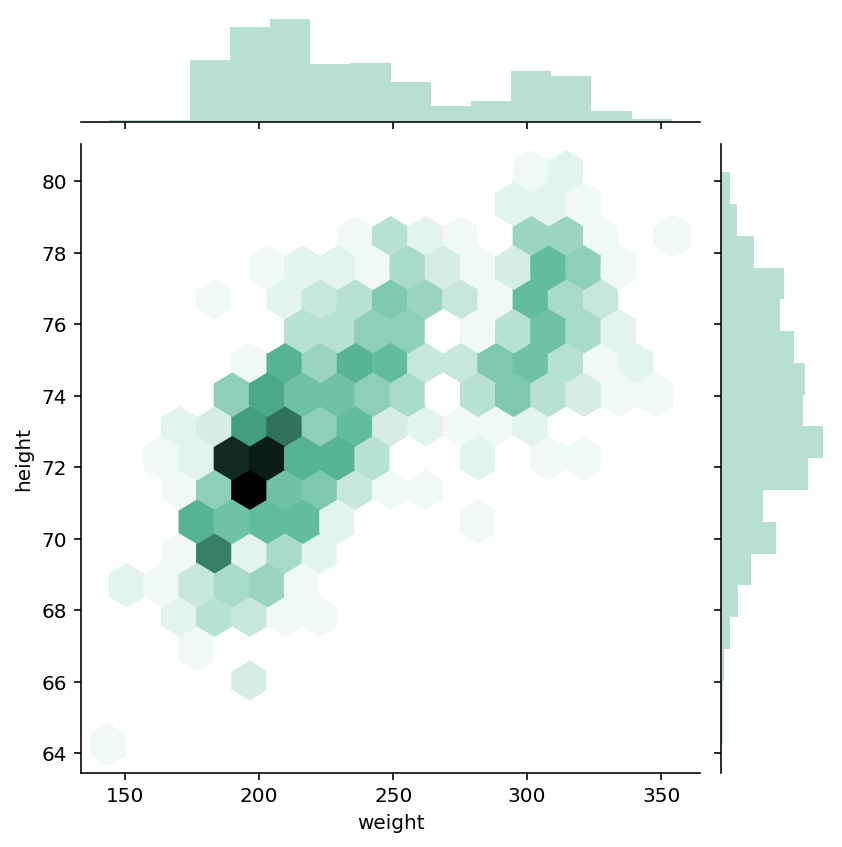

In [22]:
sns.jointplot(x='weight', y='height', data=clean_df, kind="hex", color="#4CB391")

This plot lets us see where the highest density of players are - in the 190-200 weight range, around 71-73 inches tall

What about seeing how all these variables relate to eachother?

Text(0.5, 0.98, 'How do Pro Day measurables relate to eachother?')

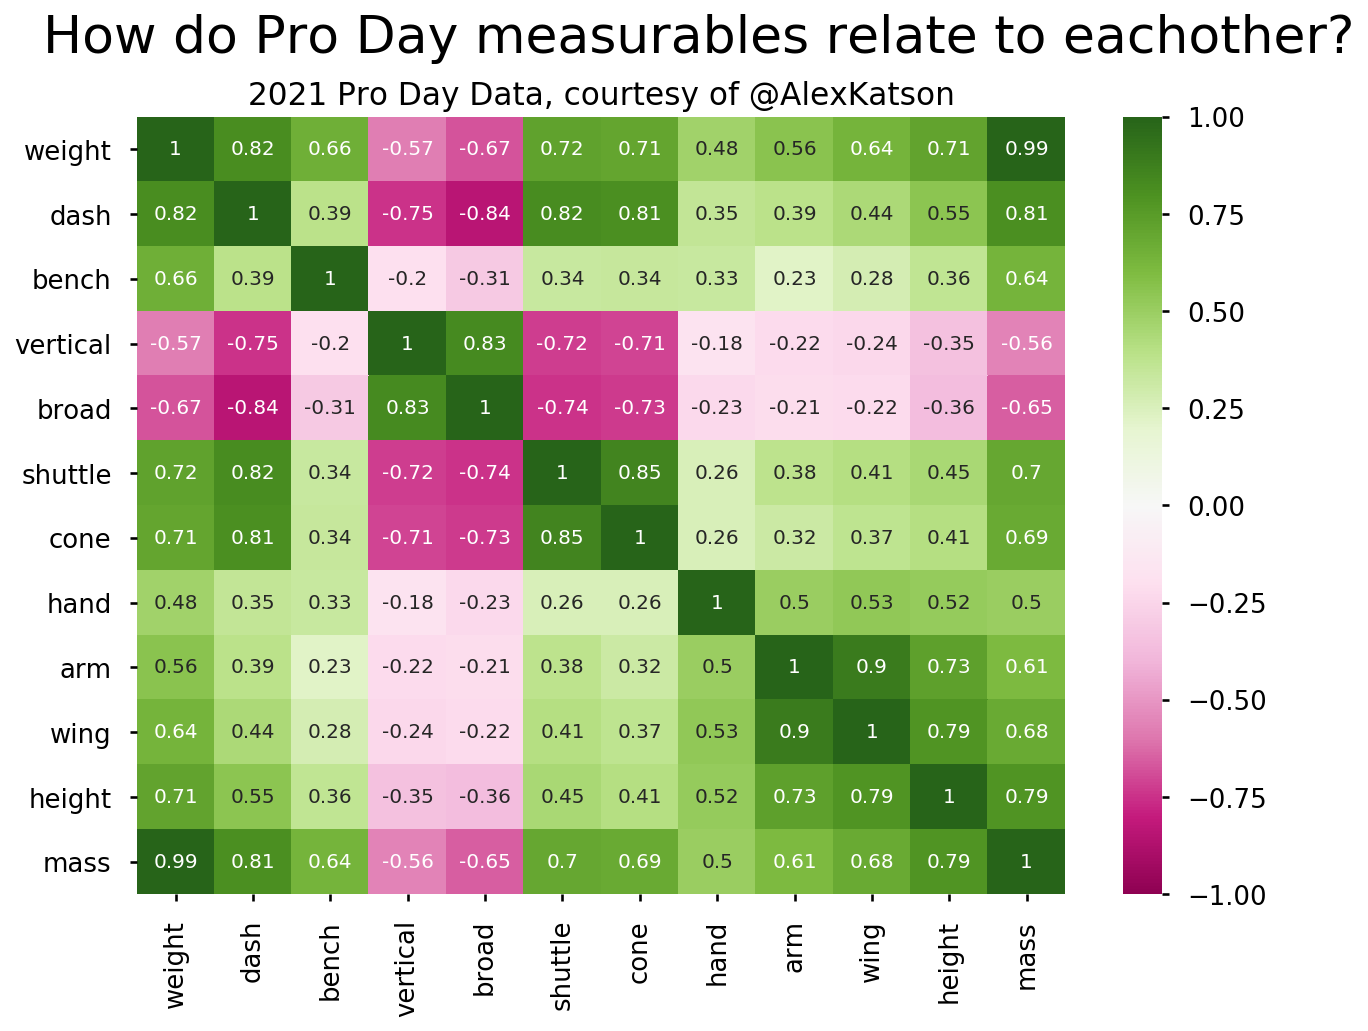

In [23]:
#Setting a "Style" of plots, which is cleaner and slightly bigger than what we've been using. 
#We could do all this manually, but this is much faster
plt.style.use('seaborn-talk')
#Very simple, but poweful one-liner here
sns.heatmap(clean_df.corr(), annot=True, cmap='PiYG', vmin=-1, vmax=1);
plt.title('2021 Pro Day Data, courtesy of @AlexKatson')
plt.suptitle('How do Pro Day measurables relate to eachother?', fontsize=26)

The green numbers here represent a positive correlation, while the purple colors represent a negative correlation. The darker the color, the stronger the relationship between variables. 

This is a very cool plot imo. We can immediately see how strong of a relationship these athletic tests have, and also their relationship to some anthropometric variables.

That's enough for this notebook. Next time I'll walkthrough building a model with some of these metrics.